# Combining ARIMA with Decomposition

We've already gone through the process of a simple ARIMA model. In this exercise we're going to build on that slightly by using a combination of an ARIMA model with the `seasonal decompose` tool you saw in the lecture. There are models we can use __specifically__ for dealing with seasonality, but we're going to go step by step here and manually pull apart this time series so we fully understand it and some of the issues we can have when working with TS data.

For this challenge we're going to be working with the daily CO2 ppm measurements, specifically, the daily CO2 measurements from the Mauna Loa Observatory 🌋

They have been taken since since 1958, and are a cornerstone of climate science. Perched at over 3,000 meters in Hawaii, the observatory is well-positioned to monitor global atmospheric carbon levels, largely free from local emissions. While the record is robust, __it does contain gaps due to occasional instrument issues or extreme weather__, which researchers must account for in their analyses to maintain the integrity of this critical dataset.  We'll be using a portion of data that has been taken __almost__ daily since 1974 - we will address the gaps in the data throughout the course of the notebook!

If you're curious about the climate work done by the lab, you can read more about it here: https://gml.noaa.gov/ccgg/about/co2_measurements.html

## Loading and exploring the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/09-Time-Series/co2_daily_mlo.csv")

In [3]:
df

,year,month,day,CO2 molfrac (ppm)
0,1974,5,17,333.38
1,1974,5,18,333.11
2,1974,5,19,333.46
3,1974,5,20,333.64
4,1974,5,21,333.50
...,...,...,...,...
15191,2023,10,19,419.44
15192,2023,10,20,419.53
15193,2023,10,21,418.90
15194,2023,10,23,419.09


We can see the data isn't formatted very nicely for us to work with, so let's solve that step first by using `pd.to_datetime()` (you can use the function on multiple columns at once 👀). Check the [docs](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) to find out more.

Once you've formatted it correctly, set it as your index.

In [4]:
# Converting the year, month, and day columns to a single datetime column
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.set_index('date', inplace=True)
df.drop(columns=['year', 'month', 'day'], inplace=True)

# Verify the formatting
df.head()


,CO2 molfrac (ppm)
date,
1974-05-17,333.38
1974-05-18,333.11
1974-05-19,333.46
1974-05-20,333.64
1974-05-21,333.50


Plot out your CO2 values and discuss with your partner what you see. Does it look like you have any gaps in your data? Are you __sure__? Check the top 50 values of your DataFrame

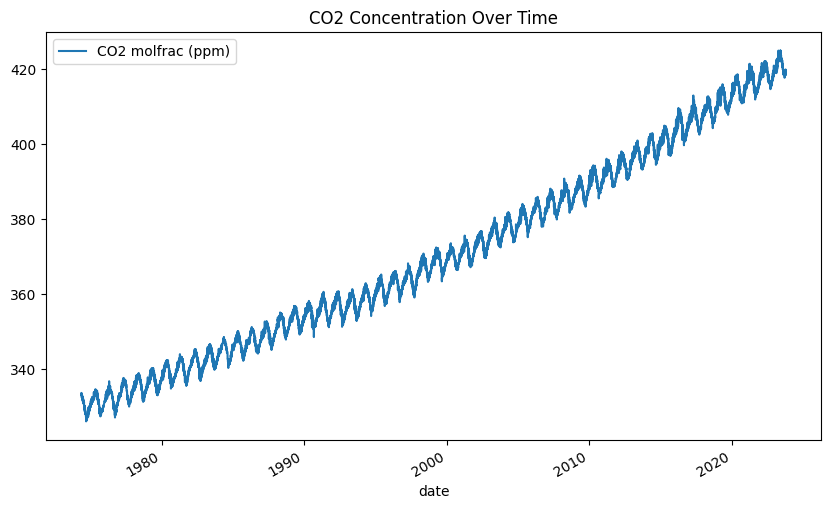

In [5]:
# Check the first 50 values and plot the data
df.head(50)
df.plot(y="CO2 molfrac (ppm)", figsize=(10, 6))
plt.title("CO2 Concentration Over Time")
plt.show()

We're missing some dates 😱 Even though we don't have any obvious `NaN` values, there are missing dates from our index. This is something you need to be __really__ careful about with TS data.

Let's work out how many days we're missing. Subtracting your end date (the `max()` of your `index`) from your start date (the `min()` of your `index`)to see how many days __should__ between the two.

In [7]:
# Calculate the total number of days between the first and last date
expected_days = (df.index.max() - df.index.min()).days

# Actual number of records
actual_days = df.shape[0]



How does this differ from the number of days we __actually__ have in our DataFrame? Save your answer to a variable `missing`

In [8]:
# Number of missing days
missing = expected_days - actual_days
missing


2861

In [9]:
from nbresult import ChallengeResult

result = ChallengeResult('missing',
                         missing = missing)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/amralghasham/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/amralghasham/code/Amralghasham/data-arima-101/tests
plugins: typeguard-2.13.3, anyio-3.6.2, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 1 item

test_missing.py::TestMissing::test_missing PASSED                        [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/missing.pickle

git commit -m 'Completed missing step'

git push origin master



Let's actually see where are missing values lie. Use `pd.date_range` to create the index we __should__ have. Then use the DataFrame's `.reindex()` function with this new date range to see where our null values actually are in our first 100 entries!

In [10]:
# Create a full date range and reindex the DataFrame
full_index = pd.date_range(start=df.index.min(), end=df.index.max())
df_reindexed = df.reindex(full_index)

# Interpolate missing values
df_reindexed['CO2 molfrac (ppm)'] = df_reindexed['CO2 molfrac (ppm)'].interpolate()
df_reindexed.head(100)


,CO2 molfrac (ppm)
1974-05-17,333.380
1974-05-18,333.110
1974-05-19,333.460
1974-05-20,333.640
1974-05-21,333.500
...,...
1974-08-20,329.070
1974-08-21,329.410
1974-08-22,329.085
1974-08-23,328.760


We simplest option here is to use the very useful `pd.interpolate("linear")` function to fill these in for us. Try running the cell below to see what it does:

<AxesSubplot:xlabel='date'>

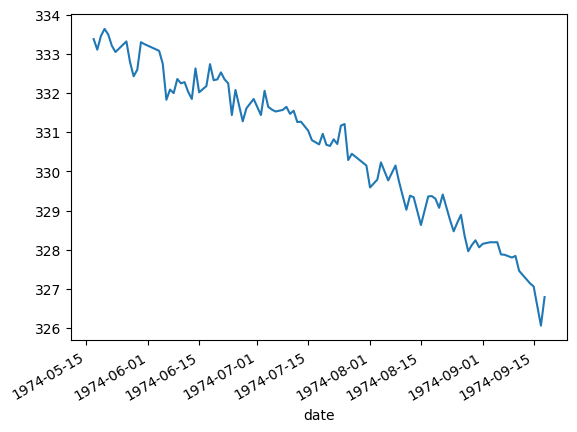

In [11]:
df["CO2 molfrac (ppm)"][:100].interpolate("linear").plot()

Interpolation uses a simple linear method to connect the dots for us 😊 Obviously this is making some assumptions that aren't perfectand we don't actually need to have daily samples - instead we'll `resample` our DataFrame on a monthly basis and try to model that. Try using the `.resample()` function to create a DataFrame with each month's average and name it `monthly`. See [docs](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) here.

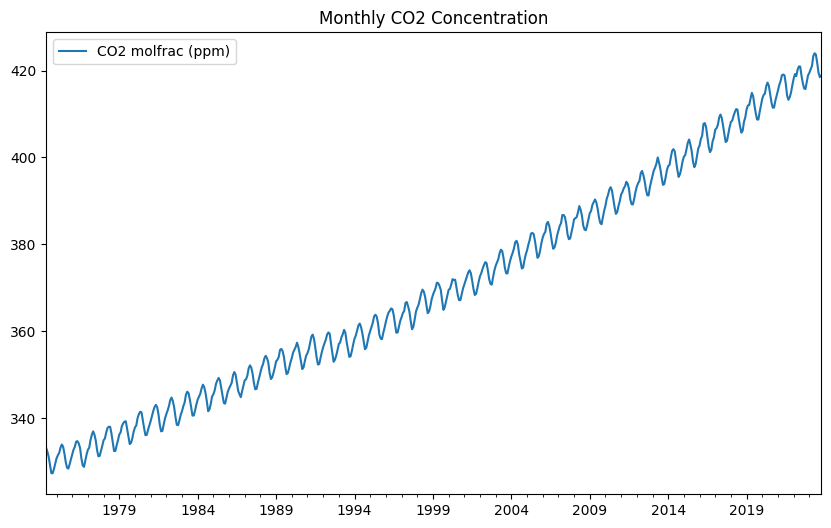

333.16066666666666

In [12]:
# Resample to monthly data by taking the mean for each month
monthly = df_reindexed.resample('M').mean()

# Check for any remaining null values and interpolate them if necessary
monthly['CO2 molfrac (ppm)'] = monthly['CO2 molfrac (ppm)'].interpolate()
monthly.plot(y="CO2 molfrac (ppm)", figsize=(10, 6))
plt.title("Monthly CO2 Concentration")
plt.show()

# First value check
monthly['CO2 molfrac (ppm)'].iloc[0]


If you __still__ have any remaining null values, you can use the `interpolate` to fill them in. Plot out your resampled data:

In [ ]:
# YOUR CODE HERE

<AxesSubplot:>

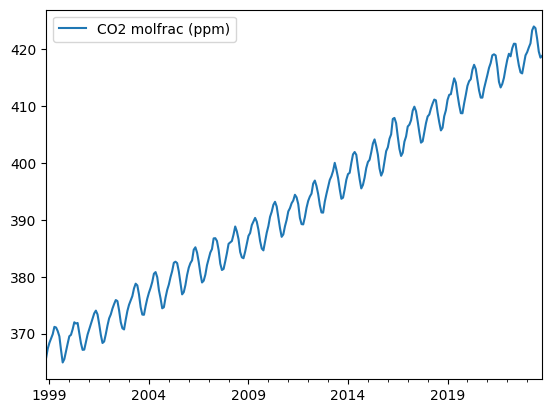

In [13]:
monthly[-300:].plot()

In [14]:
monthly["CO2 molfrac (ppm)"][0]

333.16066666666666

In [15]:
from nbresult import ChallengeResult

result = ChallengeResult('monthly',
                         monthly = monthly)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/amralghasham/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/amralghasham/code/Amralghasham/data-arima-101/tests
plugins: typeguard-2.13.3, anyio-3.6.2, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 2 items

test_monthly.py::TestMonthly::test_first_value PASSED                    [ 50%]
test_monthly.py::TestMonthly::test_missing PASSED                        [100%]

============================== 2 passed in 0.43s ===============================


💯 You can commit your code:

git add tests/monthly.pickle

git commit -m 'Completed monthly step'

git push origin master



## Train test split

Next up we need to split into a train and test set (we'll do an 80:20 split). Be cautious when doing this - we need our sets to be __continuous__!

In [16]:
# Perform an 80:20 train-test split on the monthly dataset
split_point = int(0.8 * len(monthly))
train = monthly[:split_point]
test = monthly[split_point:]

train.shape, test.shape


((475, 1), (119, 1))

Our data preparation is almost done. Before we start decomposing and modelling though, we should come up with a baseline to see how our model performs. 

The typical baselines we'd pick is just to guess the last aviable value to us. In our case, this is simply the final point in our `train` DataFrame.

In your `test` DataFrame, create a column called `naive_preds` and set it to be equal to our last avaialable data point in `train`


In [19]:
# Baseline prediction (last value in the training set)
last_train_value = train["CO2 molfrac (ppm)"].iloc[-1]

# Create a deep copy of the test DataFrame to avoid the SettingWithCopyWarning
test_copy = test.copy()

# Assign the last value of the train data as the naive prediction
test_copy['naive_preds'] = last_train_value

Once you have this, caclulate the mean absolute error between the two columns and set this as your `baseline_mae`.

In [20]:
# Calculate the baseline MAE
baseline_mae = np.mean(np.abs(test_copy["CO2 molfrac (ppm)"] - test_copy['naive_preds']))
baseline_mae

14.501157271050824

In [21]:
from nbresult import ChallengeResult

result = ChallengeResult('baseline',
                         test = test,
                         baseline_mae = baseline_mae)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/amralghasham/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/amralghasham/code/Amralghasham/data-arima-101/tests
plugins: typeguard-2.13.3, anyio-3.6.2, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 3 items

test_baseline.py::TestBaseline::test_baseline_mae PASSED                 [ 33%]
test_baseline.py::TestBaseline::test_first_value PASSED                  [ 66%]
test_baseline.py::TestBaseline::test_missing PASSED                      [100%]

============================== 3 passed in 0.45s ===============================


💯 You can commit your code:

git add tests/baseline.pickle

git commit -m 'Completed baseline step'

git push origin master



## Getting ready to model

For some Time Series models, we can simply through our data in and hope that it will decompose it, make it stationary for us and then model it for us (SARIMAX or TBATS are good examples of this), but we're going to go step by step instead. Since we're not relying on a model to remove seasonality and trend for us, we will take care of them ourselves.

Import the `seasonal_decompose` tool that you saw in the lecture and try both methods on your Time Series (both "multiplicative" and "additive"). 

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition (multiplicative and additive)
result_multiplicative = seasonal_decompose(train["CO2 molfrac (ppm)"], model="multiplicative")
result_additive = seasonal_decompose(train["CO2 molfrac (ppm)"], model="additive")




Plot the residuals (access the `.resid` attribute) from both and remember - we want the one that looks as __non-influenced__ by time as possible

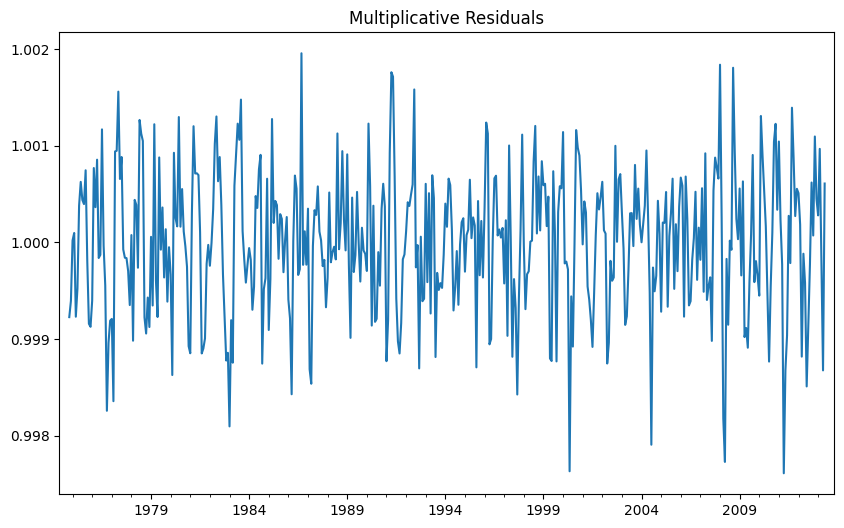

In [25]:
# Plot the residuals to check stationarity
result_multiplicative.resid.plot(figsize=(10,6), title="Multiplicative Residuals")
plt.show()



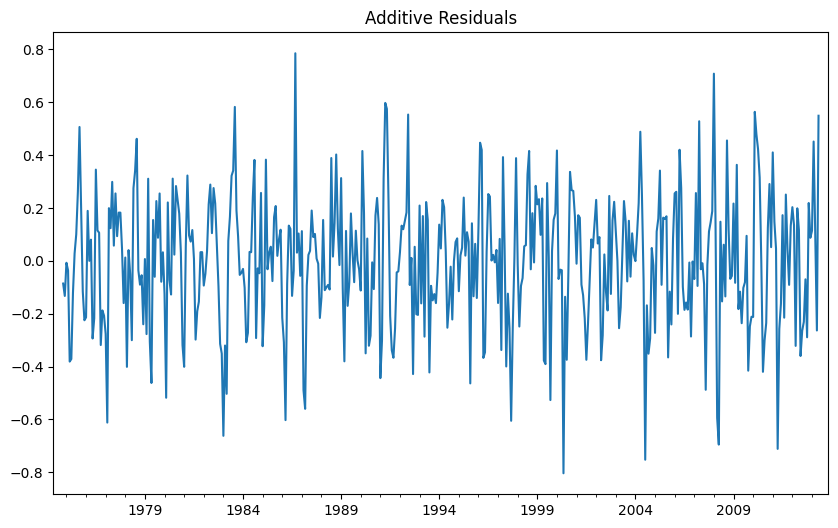

In [24]:
result_additive.resid.plot(figsize=(10,6), title="Additive Residuals")
plt.show()

Since both look reasonably stationary, we'll pick the multiplicative model.

Our strategy now is to take out the seasonal component of our time series. 

How can we do this? 🤔


First, create a column called `"seasonal_component"`in your `train` DataFrame that is filled with the `.seasonal` component of your time series. 

After you do this, create a separate, smaller DataFrame that only includes __one year__ of seasonal components (ie. the first 12 rows of your `seasonal components` column). This will be useful for us later on. Name it `seasonal_one_year` and make sure you have a `"month"` column equal to the corresponding `index.month` (e.g. you have have a row with the January seasonal component and a 1 next to it). 

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/seasonal_component_one.png">

In [26]:
# Create the seasonal component column in the train DataFrame
train['seasonal_component'] = result_multiplicative.seasonal

# Create a separate DataFrame for one year of seasonal components
seasonal_one_year = train[['seasonal_component']].iloc[:12]
seasonal_one_year['month'] = seasonal_one_year.index.month
seasonal_one_year


/tmp/ipykernel_9534/3547446852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['seasonal_component'] = result_multiplicative.seasonal


,seasonal_component,month
1974-05-31,1.008457,5
1974-06-30,1.006537,6
1974-07-31,1.001817,7
1974-08-31,0.995704,8
1974-09-30,0.990936,9
1974-10-31,0.990843,10
1974-11-30,0.994130,11
1974-12-31,0.997570,12
1975-01-31,1.000269,1
1975-02-28,1.002098,2


Since this is from a multiplicative model, if we want to __remove__ this seasonal component, we'll need to __divide__ our original time series by these repeating (12-month cycle) values.

In [27]:
from nbresult import ChallengeResult

result = ChallengeResult('seasonal',
                         train = train,
                         seasonal = seasonal_one_year)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/amralghasham/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/amralghasham/code/Amralghasham/data-arima-101/tests
plugins: typeguard-2.13.3, anyio-3.6.2, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 2 items

test_seasonal.py::TestSeasonal::test_seasonal_column PASSED              [ 50%]
test_seasonal.py::TestSeasonal::test_seasonal_year_shape PASSED          [100%]

============================== 2 passed in 0.48s ===============================


💯 You can commit your code:

git add tests/seasonal.pickle

git commit -m 'Completed seasonal step'

git push origin master



Create a new column named `"seasonal_stripped"` equal to the value of your original time series divided by the seasonal component.

In [28]:
# Strip the seasonality by dividing the original values by the seasonal component
train['seasonal_stripped'] = train["CO2 molfrac (ppm)"] / train['seasonal_component']


/tmp/ipykernel_9534/2339944266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['seasonal_stripped'] = train["CO2 molfrac (ppm)"] / train['seasonal_component']


Plot this new column out:

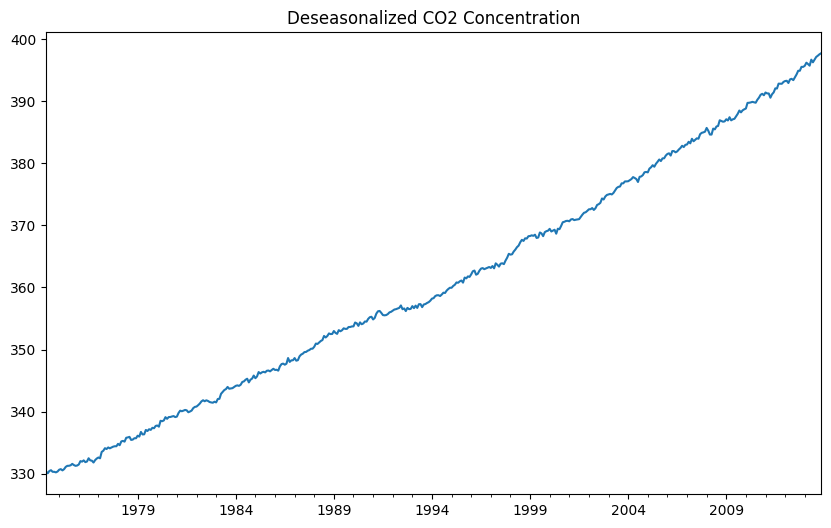

In [29]:
train['seasonal_stripped'].plot(figsize=(10,6), title="Deseasonalized CO2 Concentration")
plt.show()


Does it look stationary yet? Discuss with your buddy for the day why or why not.

Our next task is to take this __deseasonalized__ time series and to look get it stationary. Try using `.diff()` and see how it looks. Then try diffing one more time to see any changes. 

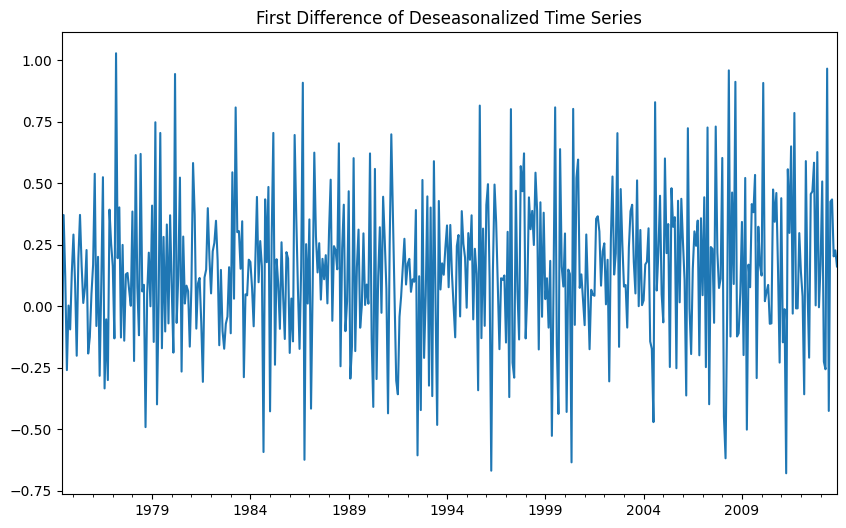

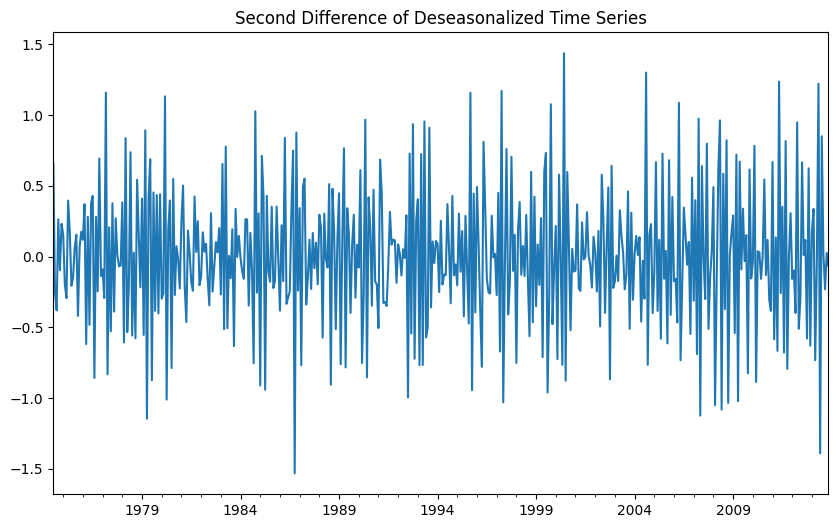

In [30]:
# First difference
deseasonalized_diff1 = train['seasonal_stripped'].diff()

# Drop NA values created by differencing
deseasonalized_diff1.dropna(inplace=True)

# Plot the first differencing
deseasonalized_diff1.plot(figsize=(10,6), title="First Difference of Deseasonalized Time Series")
plt.show()

# Second difference
deseasonalized_diff2 = deseasonalized_diff1.diff()

# Drop NA values created by the second differencing
deseasonalized_diff2.dropna(inplace=True)

# Plot the second differencing
deseasonalized_diff2.plot(figsize=(10,6), title="Second Difference of Deseasonalized Time Series")
plt.show()


In [ ]:
# YOUR CODE HERE

Both should look quite stationary visually, use the `adfuller` (Augmented Dicky-Fuller) test from the lecture to verify that each one is. 

N.B. When you `diff` you create null values in your DataFrame, you'll need to drop these to perform an ADF test.

In [31]:
from statsmodels.tsa.stattools import adfuller

# First, apply the ADF test to the first differenced series
adf_test_diff1 = adfuller(deseasonalized_diff1.dropna())  # Drop NA before running the test

# Print the ADF test results for the first difference
print("ADF Statistic (First Difference):", adf_test_diff1[0])
print("p-value (First Difference):", adf_test_diff1[1])

# Check for second difference if the first difference is not stationary
adf_test_diff2 = adfuller(deseasonalized_diff2.dropna())  # Drop NA before running the test

# Print the ADF test results for the second difference
print("ADF Statistic (Second Difference):", adf_test_diff2[0])
print("p-value (Second Difference):", adf_test_diff2[1])


ADF Statistic (First Difference): -19.065378629863016
p-value (First Difference): 0.0
ADF Statistic (Second Difference): -12.72799695170896
p-value (Second Difference): 9.509487603670812e-24


In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

Both seem to be reasonably stationary, and it looks like there's no need to overdifference (though we can always try building a twice-diffed time series later). Let's go ahead and plot our `acf` and `pacf` plots (be sure to drop any `null` values - those will break your ACF and PACF calculators) 😔

In [32]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

/home/amralghasham/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


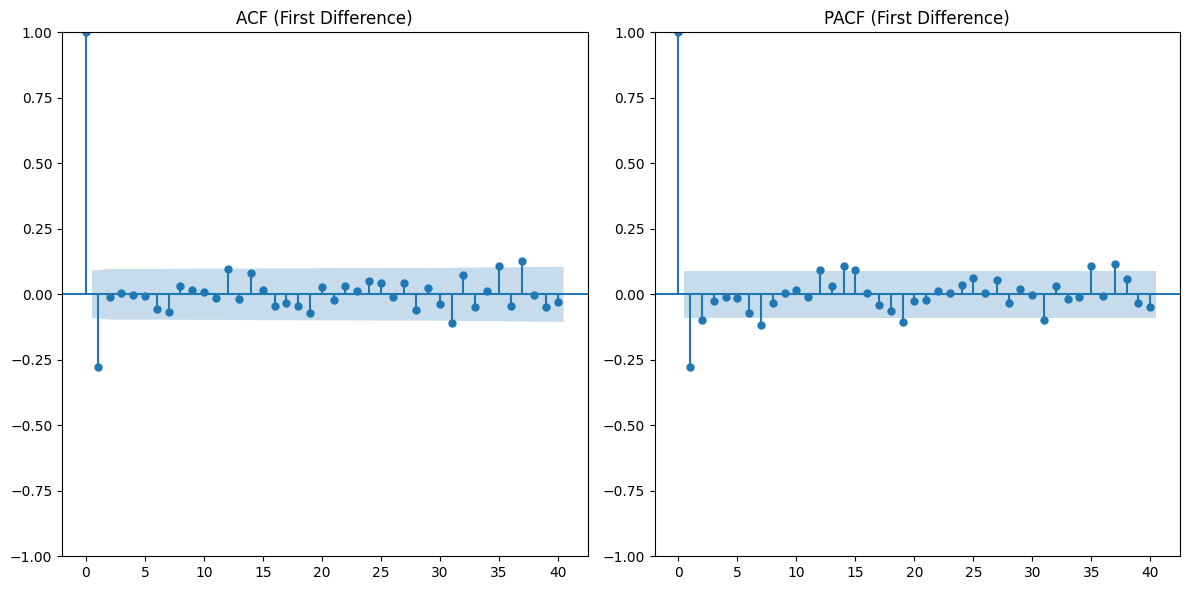

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF for the first differenced data (drop any NA values)
plt.figure(figsize=(12,6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(deseasonalized_diff1.dropna(), ax=plt.gca(), lags=40)
plt.title('ACF (First Difference)')

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(deseasonalized_diff1.dropna(), ax=plt.gca(), lags=40)
plt.title('PACF (First Difference)')

plt.tight_layout()
plt.show()


In [ ]:
# YOUR CODE HERE

Take the time to really talk through what these plots actually mean with your buddy. Which one corresponds to your `p` parameter and which corresponds to your `q` parameter?

Now build a simple ARIMA model with the appropriate order values for your `p` `d` and `q` values. Investigate its model summary.

In [34]:
from statsmodels.tsa.arima.model import ARIMA

# Set the appropriate p, d, q values based on the ACF and PACF plots.
# Example: p=1, d=1 (first differencing), q=1 (this may vary based on your ACF/PACF results)
p = 1  # Autoregressive term from PACF
d = 1  # Differencing order from ADF test
q = 1  # Moving average term from ACF

# Build and fit the ARIMA model
arima_model = ARIMA(train['seasonal_stripped'], order=(p, d, q))
arima_result = arima_model.fit()

# Investigate the model summary
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:      seasonal_stripped   No. Observations:                  475
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -113.618
Date:                Sun, 29 Sep 2024   AIC                            233.237
Time:                        09:04:05   BIC                            245.721
Sample:                    05-31-1974   HQIC                           238.147
                         - 11-30-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   2694.952      0.000       0.999       1.001
ma.L1         -0.9950      0.011    -90.602      0.000      -1.016      -0.973
sigma2         0.0939      0.006     15.754      0.0

What do you note about the summary? What are the most important features here?

It looks like we can trust our coefficients and we have an AIC of ~223. But was it the best model? Trying using the `auto_arima` function to grid search different models and see which has the best AIC

In [35]:
train

,CO2 molfrac (ppm),seasonal_component,seasonal_stripped
1974-05-31,333.160667,1.008457,330.366807
1974-06-30,332.238833,1.006537,330.081135
1974-07-31,331.052742,1.001817,330.452160
1974-08-31,329.154032,0.995704,330.574136
1974-09-30,327.321167,0.990936,330.315085
...,...,...,...
2013-07-31,397.388871,1.001817,396.667945
2013-08-31,395.396452,0.995704,397.102352
2013-09-30,393.704333,0.990936,397.305440
2013-10-31,393.892742,0.990843,397.532954


In [36]:
from pmdarima import auto_arima

# Perform auto ARIMA to find the best model based on AIC
auto_arima_model = auto_arima(train['seasonal_stripped'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)



Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=669.766, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=457.202, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=234.321, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=667.768, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=191.319, Time=0.37 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=191.246, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=189.636, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,3)(

In [ ]:
# YOUR CODE HERE

Save your best AIC score to `best_AIC`

In [37]:
best_AIC = auto_arima_model.aic()
best_AIC

189.6360395997835

In [38]:
from nbresult import ChallengeResult

result = ChallengeResult('score',
                         aic_score = best_AIC)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/amralghasham/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/amralghasham/code/Amralghasham/data-arima-101/tests
plugins: typeguard-2.13.3, anyio-3.6.2, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 1 item

test_score.py::TestScore::test_AIC_score PASSED                          [100%]

============================== 1 passed in 0.13s ===============================


💯 You can commit your code:

git add tests/score.pickle

git commit -m 'Completed score step'

git push origin master



Often times, it can be hard to predict which model with fit best on our data so it is usually a good idea to grid-search and compare your models' AIC scores 🧐 Here, it looks like a __(0,1,1)__ model gets a better AIC score (so the MA components of our original model probably weren't improving our model likelihood that much!)

### Making predictions (get ready for some Pandas work!)

Now that we have our best model, we'd like to generate some predictions and - crucially - some confidence intervals. Use your model to predict for the length of your test set and ensure that you also return those intervals (use `return_conf_int = True`). Create a `preds_df` DataFrame with columns for `preds`, `upper` and `lower` bounds.

In [43]:
# Ensure the test DataFrame has a 'month' column
test['month'] = test.index.month

# Ensure the predictions DataFrame also has a 'month' column
preds_df['month'] = test['month'].values

# Check the seasonal_one_year DataFrame has the correct 'month' column
seasonal_one_year['month'] = seasonal_one_year.index.month

# Now merge preds_df with the seasonal component DataFrame (seasonal_one_year) on 'month'
preds_df = preds_df.merge(seasonal_one_year, on='month', how='left')

# Reapply the seasonal component to predictions
preds_df['full_preds'] = preds_df['preds'] * preds_df['seasonal_component']
preds_df['upper_conf'] = preds_df['upper'] * preds_df['seasonal_component']
preds_df['lower_conf'] = preds_df['lower'] * preds_df['seasonal_component']


/tmp/ipykernel_9534/130273675.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test.index.month


In [44]:
from nbresult import ChallengeResult

result = ChallengeResult('preds',
                         preds_df = preds_df)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/amralghasham/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/amralghasham/code/Amralghasham/data-arima-101/tests
plugins: typeguard-2.13.3, anyio-3.6.2, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 2 items

test_preds.py::TestPreds::test_df_values PASSED                          [ 50%]
test_preds.py::TestPreds::test_preds_cols PASSED                         [100%]

============================== 2 passed in 0.43s ===============================


💯 You can commit your code:

git add tests/preds.pickle

git commit -m 'Completed preds step'

git push origin master



Now plot them, out and see how they look compared alongside your `train` data

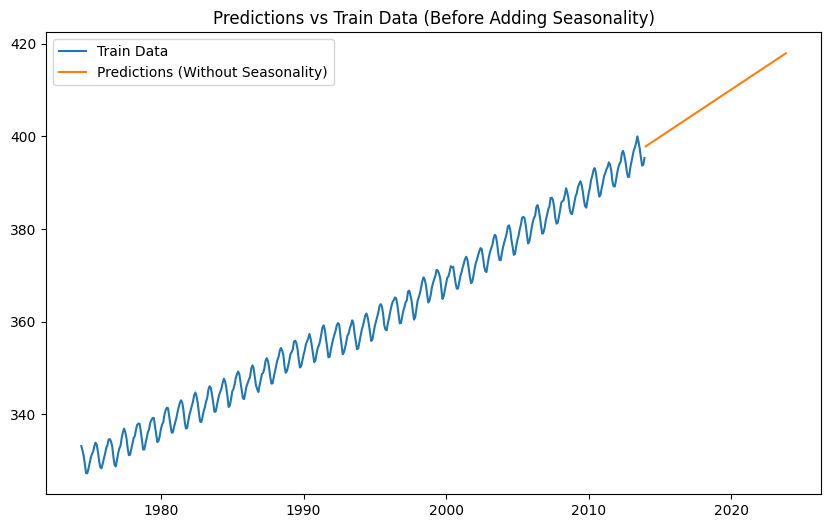

In [45]:
# Plot the last part of the train data and the naive predictions
plt.figure(figsize=(10,6))

# Plot the training data
plt.plot(train.index, train["CO2 molfrac (ppm)"], label="Train Data")

# Plot the predictions (without the seasonal component)
plt.plot(test.index, preds_df['preds'], label="Predictions (Without Seasonality)")

plt.title("Predictions vs Train Data (Before Adding Seasonality)")
plt.legend()
plt.show()


Something looks a bit wrong doesn't it? We're looking at three straight lines coming out of something that clearly had seasonality. To account for this, we need to re-incorporate the seasonality component that we extracted earlier!

Create a `month` column in your `test` DataFrame and populate it with the month component of the index. 

In [47]:
# Add the 'month' column to the test DataFrame
test['month'] = test.index.month



/tmp/ipykernel_9534/1847541061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test.index.month


In [48]:

# Confirm it has been added
test.head()

,CO2 molfrac (ppm),naive_preds,month
2013-12-31,397.056290,395.360667,12
2014-01-31,398.043226,395.360667,1
2014-02-28,398.263750,395.360667,2
2014-03-31,400.001774,395.360667,3
2014-04-30,401.509167,395.360667,4


Now we can take our `seasonal_one_year` DataFrame that we made earlier and simply merge it onto our `preds_df`!

In [49]:
# Ensure preds_df also has a 'month' column from the test DataFrame
preds_df['month'] = test['month'].values



In [50]:
# Merge preds_df with seasonal_one_year based on 'month'
preds_df = preds_df.merge(seasonal_one_year, on='month', how='left')


In [51]:

# Check the merged DataFrame
preds_df.head()


,preds,upper,lower,month,seasonal_component_x,full_preds,upper_conf,lower_conf,seasonal_component_y
0,397.857376,398.430321,397.284430,12,0.997570,396.890530,397.462083,396.318977,0.997570
1,398.027689,398.722121,397.333257,1,1.000269,398.134617,398.829236,397.439998,1.000269
2,398.198003,398.997584,397.398422,2,1.002098,399.033375,399.834633,398.232116,1.002098
3,398.368316,399.262508,397.474124,3,1.004327,400.091893,400.989954,399.193833,1.004327
4,398.538630,399.519963,397.557296,4,1.007312,401.452802,402.441311,400.464293,1.007312


In [52]:
preds_df

,preds,upper,lower,month,seasonal_component_x,full_preds,upper_conf,lower_conf,seasonal_component_y
0,397.857376,398.430321,397.284430,12,0.997570,396.890530,397.462083,396.318977,0.997570
1,398.027689,398.722121,397.333257,1,1.000269,398.134617,398.829236,397.439998,1.000269
2,398.198003,398.997584,397.398422,2,1.002098,399.033375,399.834633,398.232116,1.002098
3,398.368316,399.262508,397.474124,3,1.004327,400.091893,400.989954,399.193833,1.004327
4,398.538630,399.519963,397.557296,4,1.007312,401.452802,402.441311,400.464293,1.007312
...,...,...,...,...,...,...,...,...,...
114,417.273115,424.021993,410.524237,6,1.006537,420.000776,426.793770,413.207781,1.006537
115,417.443428,424.244865,410.641992,7,1.001817,418.202113,425.015911,411.388314,1.001817
116,417.613742,424.467823,410.759660,8,0.995704,415.819727,422.644364,408.995090,0.995704
117,417.784055,424.690868,410.877243,9,0.990936,413.997334,420.841544,407.153124,0.990936


Now you can create your `full_preds`, `upper_conf` and `lower_conf` (create them as new columns in the `preds_df` DataFrame) by multiplying out your `preds`, `upper` __and__ `lower` columns with the seasonal component that we now have in our `preds_df` DataFrame.

In [54]:
# Check the seasonal_one_year DataFrame
print(seasonal_one_year.head())

# Ensure it has the 'seasonal_component' and 'month' columns
if 'seasonal_component' not in seasonal_one_year.columns or 'month' not in seasonal_one_year.columns:
    print("The 'seasonal_component' or 'month' column is missing!")


            seasonal_component  month
1974-05-31            1.008457      5
1974-06-30            1.006537      6
1974-07-31            1.001817      7
1974-08-31            0.995704      8
1974-09-30            0.990936      9


In [55]:
# Make sure the seasonal_component column is in seasonal_one_year
seasonal_one_year = train[['seasonal_component']].iloc[:12]
seasonal_one_year['month'] = seasonal_one_year.index.month


In [56]:
# Ensure preds_df has the month column from the test DataFrame
preds_df['month'] = test.index.month

# Check the preds_df
print(preds_df.head())


        preds       upper       lower  month  seasonal_component_x  \
0  397.857376  398.430321  397.284430     12              0.997570   
1  398.027689  398.722121  397.333257      1              1.000269   
2  398.198003  398.997584  397.398422      2              1.002098   
3  398.368316  399.262508  397.474124      3              1.004327   
4  398.538630  399.519963  397.557296      4              1.007312   

   full_preds  upper_conf  lower_conf  seasonal_component_y  
0  396.890530  397.462083  396.318977              0.997570  
1  398.134617  398.829236  397.439998              1.000269  
2  399.033375  399.834633  398.232116              1.002098  
3  400.091893  400.989954  399.193833              1.004327  
4  401.452802  402.441311  400.464293              1.007312  


In [57]:
# Merge preds_df with the seasonal_one_year DataFrame
preds_df = preds_df.merge(seasonal_one_year, on='month', how='left')

# Check the merged DataFrame to ensure seasonal_component is included
print(preds_df.head())


        preds       upper       lower  month  seasonal_component_x  \
0  397.857376  398.430321  397.284430     12              0.997570   
1  398.027689  398.722121  397.333257      1              1.000269   
2  398.198003  398.997584  397.398422      2              1.002098   
3  398.368316  399.262508  397.474124      3              1.004327   
4  398.538630  399.519963  397.557296      4              1.007312   

   full_preds  upper_conf  lower_conf  seasonal_component_y  \
0  396.890530  397.462083  396.318977              0.997570   
1  398.134617  398.829236  397.439998              1.000269   
2  399.033375  399.834633  398.232116              1.002098   
3  400.091893  400.989954  399.193833              1.004327   
4  401.452802  402.441311  400.464293              1.007312   

   seasonal_component  
0            0.997570  
1            1.000269  
2            1.002098  
3            1.004327  
4            1.007312  


In [58]:
# Reapply the seasonal component to predictions
preds_df['full_preds'] = preds_df['preds'] * preds_df['seasonal_component']
preds_df['upper_conf'] = preds_df['upper'] * preds_df['seasonal_component']
preds_df['lower_conf'] = preds_df['lower'] * preds_df['seasonal_component']

# Check if full_preds, upper_conf, and lower_conf columns are properly calculated
print(preds_df[['full_preds', 'upper_conf', 'lower_conf']].head())


   full_preds  upper_conf  lower_conf
0  396.890530  397.462083  396.318977
1  398.134617  398.829236  397.439998
2  399.033375  399.834633  398.232116
3  400.091893  400.989954  399.193833
4  401.452802  402.441311  400.464293


Finally, to make plotting easier for us, set the index of your `preds_df` to be the same as the index of your `test` DataFrame (since they have the same length this should be quite easy for us!)

In [59]:
# Set the index of preds_df to be the same as the test DataFrame
preds_df.index = test.index

# Confirm the indices match
preds_df.head()


,preds,upper,lower,month,seasonal_component_x,full_preds,upper_conf,lower_conf,seasonal_component_y,seasonal_component
2013-12-31,397.857376,398.430321,397.284430,12,0.997570,396.890530,397.462083,396.318977,0.997570,0.997570
2014-01-31,398.027689,398.722121,397.333257,1,1.000269,398.134617,398.829236,397.439998,1.000269,1.000269
2014-02-28,398.198003,398.997584,397.398422,2,1.002098,399.033375,399.834633,398.232116,1.002098,1.002098
2014-03-31,398.368316,399.262508,397.474124,3,1.004327,400.091893,400.989954,399.193833,1.004327,1.004327
2014-04-30,398.538630,399.519963,397.557296,4,1.007312,401.452802,402.441311,400.464293,1.007312,1.007312


In [60]:
from nbresult import ChallengeResult

result = ChallengeResult('fullpreds',
                         preds_df = preds_df)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/amralghasham/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/amralghasham/code/Amralghasham/data-arima-101/tests
plugins: typeguard-2.13.3, anyio-3.6.2, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 2 items

test_fullpreds.py::TestFullpreds::test_columns PASSED                    [ 50%]
test_fullpreds.py::TestFullpreds::test_index PASSED                      [100%]

============================== 2 passed in 0.26s ===============================


💯 You can commit your code:

git add tests/fullpreds.pickle

git commit -m 'Completed fullpreds step'

git push origin master



Now plot everything out - the end of your train (e.g. the last 100 values, your full predictions, upper and lower confidence bounds and the true values from your `preds_df` DataFrame __and__ your baseline!

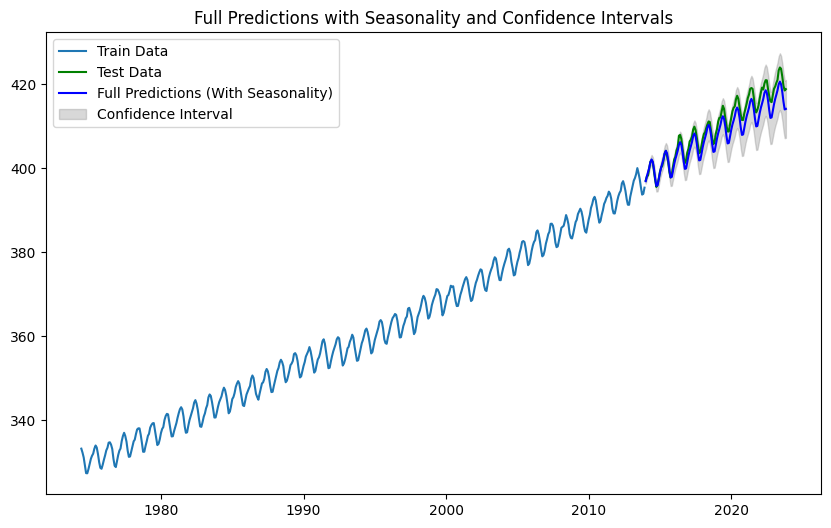

In [61]:
# Plot the full predictions along with confidence intervals and the original test data
plt.figure(figsize=(10,6))

# Plot the train data
plt.plot(train.index, train["CO2 molfrac (ppm)"], label="Train Data")

# Plot the true test data
plt.plot(test.index, test["CO2 molfrac (ppm)"], label="Test Data", color='green')

# Plot the full predictions (with seasonality)
plt.plot(preds_df.index, preds_df['full_preds'], label="Full Predictions (With Seasonality)", color='blue')

# Plot the upper and lower confidence intervals
plt.fill_between(preds_df.index, preds_df['lower_conf'], preds_df['upper_conf'], color='gray', alpha=0.3, label="Confidence Interval")

plt.title("Full Predictions with Seasonality and Confidence Intervals")
plt.legend()
plt.show()


Our predictions look pretty good! We can see that the true values are slightly higher than what we predicted but remains well within the bounds of our confidence intervals for a full 10 years out from when we started making our predictions.

Why did our values dip below the true values? Run the cell below to decompose the test data and take a look at the trend component 👀


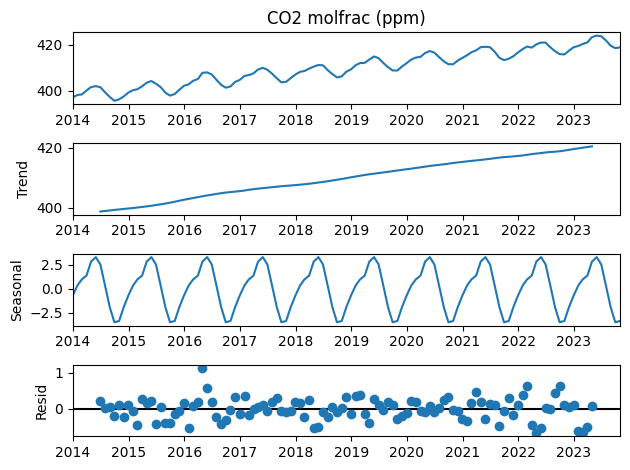

In [62]:
seasonal_decompose(test["CO2 molfrac (ppm)"]).plot();

It looks like in 2016-2018 there was a __slight rise__ in all of our values before the regular (slightly shallower) trend took over again. This is a great example of something occuring in our test dataset that we simply cannot predict. We don't know why there was a surge in CO2 readings - and we couldn't predict for it.

❗ When we model with Time Series, we __cannot magically predict the future__. What we're trying to do is accurately capture and then extend the patterns of the past. 

- Often times, your raw predictions (without a seasonal component) will look like a fairly boring straight line 🙄 (as our current initial ones did) but this is what we'd expect
- Some of the most value that we get out when doing Time Series analysis lies in being able to __quantify__ our trends, seasonal components and our confidence intervals so we can make well-informed decisions ✅

Finally, let's quickly quantify how much better our model was than our baseline. Calculate the mean absolute error between your `preds` (with their seasonal component) and the true values. See if your `model_mae` is lower than the original `baseline_mae`. 

In [63]:
model_mae = (test["CO2 molfrac (ppm)"] - preds_df["full_preds"]).mean()

In [64]:
# Calculate the mean absolute error (MAE) between the true values and the full predictions
model_mae = np.mean(np.abs(test["CO2 molfrac (ppm)"] - preds_df["full_preds"]))

# Print the model MAE to compare with baseline MAE
print(f"Model MAE: {model_mae}")
print(f"Baseline MAE: {baseline_mae}")

# Check if the model performs better than the baseline
if model_mae < baseline_mae:
    print("The model performs better than the baseline.")
else:
    print("The model does not perform better than the baseline.")


Model MAE: 2.01633727456595
Baseline MAE: 14.501157271050824
The model performs better than the baseline.


Our final MAE should be __much__ better than our original baseline. Great work 🥳 In the next notebook, we'll explore how we can use Facebook Prophet to quickly make powerful predictions without the need for decomposition.